In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# define graph general property
left_range = -256#-512
right_range = 257#513
mesh_step = 1

pat = np.arange(left_range, right_range, mesh_step)
X, Y = np.meshgrid(pat, pat)

tot_range = right_range - left_range
center = int((tot_range -1)/2)

def angle(deg):
    return deg/180 * np.pi

def calculate_2dfft(graph):
    ft = np.fft.ifftshift(graph)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    return ft
#    return abs(ft)

def calculate_2difft(graph):
    ift = np.fft.ifftshift(graph)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift
#    return ift.real

def distance_two_points(pt1, pt2):
    return np.sqrt( (pt1[0]-pt2[0]) **2 + (pt1[1]-pt2[1]) **2 )


#coords_left_half = (
#    (x, y) for x in range(array_size) for y in range(centre+1)
#)
# Sort points based on distance from centre
#coords_left_half = sorted(
#    coords_left_half,
#    key=lambda x: calculate_distance_from_centre(x, centre)
#)



#### Parameters Change Section

In [2]:
wavelength = 488 #nm
refraction_index = 1.33
mag_factor = 2

# define NA
# notice that NA affects on k-space and make k = NA/wavelength
NA_max_num = 0.6 # k_max = NA_max/n in unit_physics
NA_min_num = 0.56
# define gaussian width for bound function
gaussian_width = 50

#incoherent weight pair
#amp = (np.sqrt(2),1) # top : side
amp = (1,1)

folder_name = 'Incoherent_HEX_0.6_0.56_1/'
folder_path = 'C:\\Users\\Jacky Li\\OneDrive\\Tianming\'s Lab\\' + folder_name
saveflag = 0
if saveflag:
    Path(folder_path).mkdir(parents=True, exist_ok=True)

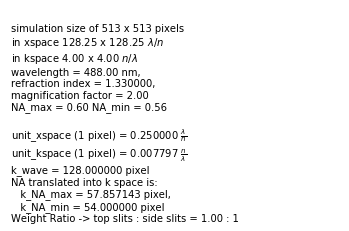

In [3]:
# define unit property
unit_physics = refraction_index/wavelength

unit_kspace = 2*mag_factor/tot_range # 1 pixel = unit_kspace in unit_physics of <n/lambda>
unit_xspace = 1/2/mag_factor # 1 pixel = unit_xspace in 1/unit_physics of <lambda/n>

k_wave = int(1/unit_kspace) # pixels! physics = k_wave*unit_kspace = tot_range/magfactor

#unit_conversion(unit_kspace,1,tot_range/2)

def unit_conversion(unit1,unit2, quantity):
    #convert quantity of unit2 into equal in unit1
    return quantity*(unit1/unit2)

def bound_gaussian(x, a):
    return np.exp(-(x*x)/(2*a*a))
# HMFW = 2.355*a

def get_full_width(x: np.ndarray, y: np.ndarray, height = 0.5):
    height_half_max = np.max(y) * height
    index_max = np.argmax(y)
    x_low = np.interp(height_half_max, y[:index_max+1], x[:index_max+1])
    x_high = np.interp(height_half_max, np.flip(y[index_max:]), np.flip(x[index_max:]))

    return x_high - x_low

# document string
str = "simulation size of %d x %d pixels \n" %(tot_range,tot_range)
str += "in xspace %.2lf x %.2lf $\\lambda/n$ \n" %(tot_range*unit_xspace,tot_range*unit_xspace)
str += "in kspace %.2lf x %.2lf $n/\lambda$ \n" %(tot_range*unit_kspace,tot_range*unit_kspace)
str += "wavelength = %.2lf nm, \nrefraction index = %lf, \nmagnification factor = %.2lf \nNA_max = %.2lf NA_min = %.2lf \n" %(wavelength,refraction_index,mag_factor,NA_max_num,NA_min_num)

NA_max = unit_conversion(1,unit_kspace, NA_max_num/refraction_index)
NA_min = unit_conversion(1,unit_kspace, NA_min_num/refraction_index)

str += "\nunit_xspace (1 pixel) = %lf $\\frac{\lambda}{n}$ \n" %unit_xspace
str += "unit_kspace (1 pixel) = %lf $\\frac{n}{\lambda}$ \n" %unit_kspace
str += "k_wave = %lf pixel \n" % k_wave
str += "NA translated into k space is: \n   k_NA_max = %lf pixel,\n   k_NA_min = %lf pixel" %(NA_max,NA_min)
str += "\nWeight Ratio -> top slits : side slits = %.2lf : 1" %(amp[0]/amp[1])

#print(str)

plt.text(0.01,0.01,str)
plt.axis('off')
if saveflag:
    plt.savefig(folder_path + 'info.png', bbox_inches='tight', dpi=300)
plt.show()

In [4]:
# define E_ideal property
# ideal points are in the middle of NA_max, NA_min

NA_ideal = (NA_max + NA_min)/2

hexx = int(round(NA_ideal*np.sqrt(3)/2))
hexy = int(round(NA_ideal/2))
NA_ideal = int(round(NA_ideal))

#complex(np.cos(np.pi),np.sin(np.pi))
HEX_points = (center + NA_ideal, center, amp[0]), (center - NA_ideal, center, amp[0]),\
            (center + hexy, center + hexx, amp[1]), (center - hexy, center - hexx, amp[1]),\
            (center - hexy, center + hexx, amp[1]), (center + hexy, center - hexx, amp[1])

SQR_points = (center + NA_ideal, center, amp[0]), (center - NA_ideal, center, amp[0]),\
            (center, center + NA_ideal, amp[1]), (center, center - NA_ideal, amp[1])

SW_points = (center + NA_ideal, center, amp[0]), (center - NA_ideal, center, amp[0])

TRI_points = (center + NA_ideal, center, amp[0]), (center - NA_ideal, center, amp[0]),\
            (center + hexy, center + hexx, amp[1]), (center - hexy, center + hexx, amp[1]),\
            (center, center - NA_ideal, amp[1])
#for some reason the points here to graph are (y,x) rather than (x,y)



In [25]:
loc_kspace = [center]
i = 1
step = 50
while i*step < tot_range/2:
    loc_kspace.append(center + i*step)
    loc_kspace.append(center - i*step)
    i += 1
del i, step

labels_kspace = []
for loc_i in loc_kspace:
    labels_kspace.append(round(unit_conversion(unit_kspace,1,(loc_i - center)),2))

def plot_kspace_setting(graph, title, set_range = ((0, tot_range), (0, tot_range))):
    fig,ax = plt.subplots(figsize=(5,5),dpi = 500)
    ax.imshow(abs(graph), cmap= 'hot')
    ax.set_xticks(loc_kspace)
    ax.set_xticklabels(labels_kspace)
    ax.set_yticks(loc_kspace)
    ax.set_yticklabels(labels_kspace)
    plt.xlabel("$n/\lambda$")
    plt.ylabel("$n/\lambda$")
    
    #set_range = ((center-int(k_wave), center+int(k_wave)), (center-int(k_wave), center+int(k_wave)))
    plt.xlim(set_range[0][0],set_range[0][1])
    plt.ylim(set_range[1][0],set_range[1][1])
    plt.title(title)
    if saveflag:
        plt.savefig(folder_path + title + '.png')
    plt.show()

###################################

loc_xspace = [center]
i = 1
step = 50
while i*step < tot_range/2:
    loc_xspace.append(center + i*step)
    loc_xspace.append(center - i*step)
    i += 1
del i, step

labels_xspace = []
for loc_i in loc_xspace:
    labels_xspace.append(round(unit_conversion(unit_xspace,1,(loc_i - center)),2))

def plot_xspace_setting(graph,title, set_range = ((0, tot_range),(0, tot_range))):
    fig,ax = plt.subplots(figsize=(5,5),dpi = 500)
    ax.imshow(abs(graph), cmap= 'hot')
    ax.set_xticks(loc_xspace)
    ax.set_xticklabels(labels_xspace)
    ax.set_yticks(loc_xspace)
    ax.set_yticklabels(labels_xspace)
    plt.xlabel("$\lambda/n$")
    plt.ylabel("$\lambda/n$")
    
    plt.xlim(set_range[0][0],set_range[0][1])
    plt.ylim(set_range[1][0],set_range[1][1])
    plt.title(title)
    if saveflag:
        plt.savefig(folder_path + title + '.png')
    plt.show()

#########################
def slice_graph(gh, x, inspace, title, normalize = 'on', x_lim = (-1, -1),  hmfw = 'off'):
    slice_gf = abs(gh.transpose()[x])

    if normalize == "on":
        slice_gf = slice_gf/max(slice_gf)

    fig,ax = plt.subplots(figsize=(5,5),dpi = 500)
    ax.plot(slice_gf)
    if inspace == "kspace":
        ax.set_xticks(loc_kspace)
        ax.set_xticklabels(labels_kspace,rotation = 45)
        plt.xlabel("$n/\lambda$")
    elif inspace == "xspace":
        ax.set_xticks(loc_xspace)
        ax.set_xticklabels(labels_xspace,rotation = 45)
        plt.xlabel("$\lambda/n$")
    if x_lim != (-1,-1):
        plt.xlim(x_lim[0], x_lim[1])
    plt.title(title)
    if hmfw == 'on':
        FWHM = get_full_width(np.arange(len(slice_gf))*unit_xspace, slice_gf, 0.5)
        plt.text(1,0.9,"FWHM = %.2lf" %(FWHM), c = 'b', ha='right', va='top', transform=ax.transAxes)
        
    if saveflag:
        plt.savefig(folder_path + title + '.png')
    plt.show()
    return slice_gf

In [6]:
# This Section try to build the E_ideal

def create_E_ideal_ini(E_ideal_pupil_points, slit_len = 2, plot_option = 0):
    E_ideal_ini = np.zeros(X.shape)
    E_ideal_ini = E_ideal_ini.astype(complex)

    def add_slit(graph, point, delta):
        for x in range(int(delta/2)):
            graph[point[0]+x][point[1]] = point[2]
            graph[point[0]-x][point[1]] = point[2]
        return graph

    for points in E_ideal_pupil_points:
        E_ideal_ini = add_slit(E_ideal_ini, points, slit_len)

    if plot_option:
        plot_kspace_setting(E_ideal_ini, "E_ideal_ini")
    
    return E_ideal_ini

def create_E_ideal(E_ideal_ini, plot_option = 0):
    
    E_ideal = calculate_2difft(E_ideal_ini) # this is E field

    if plot_option:
        plot_xspace_setting(E_ideal, "E_ideal")
    
    return E_ideal

In [7]:
######## DEFINE GAUSSIAN BOUND FUNCTION
######## APPLY GAUSSIAN AND FFT
def create_E_bound(E_ideal, plot_option = 0):
    
    line = []
    E_bound = []
    for i in range(tot_range):
        E_bound.append(E_ideal[i] * bound_gaussian(i-center, gaussian_width))
        line.append(bound_gaussian(i-center,gaussian_width))

    E_bound = np.array(E_bound)
    if plot_option:
        plt.plot(line)
        plt.show()
        plot_xspace_setting(E_bound, "E_bound")
    return E_bound
    
def create_pupil_E_bound(E_bound, plot_option = 0):
    pupil_E_bound = calculate_2dfft(E_bound)
    if plot_option:
        plot_kspace_setting(pupil_E_bound, "E_bound on Pupil plane")
    return pupil_E_bound


In [36]:
######## DEFINE NUMERICAL ANPRETURE

def apply_NA_mask_pupil(pupil_graph, plot_option = 0, inner_R = NA_min, outer_R = NA_max):

    def ring_mask(pt):
        dist = distance_two_points(pt, (center,center))
        if (inner_R <= dist and dist < outer_R):
            return 1
        return 0

    mask_figure = np.zeros(X.shape)
    for x in range(tot_range):
        for y in range(tot_range):
            mask_figure[x][y] = ring_mask((x,y))
            pupil_graph[x][y] *= mask_figure[x][y]

    if plot_option:
        plot_kspace_setting(mask_figure, "NA mask, in Pupil plane")
        plot_kspace_setting(pupil_graph, "Masked pupil function of E_bound")
    
    return pupil_graph


In [9]:
######## LLS generation

def create_LLS(pupil_graph, plot_option = 0):
    LLS = calculate_2difft(pupil_graph) # this is E field
    if plot_option:
        plot_xspace_setting(LLS, "E field of LLS")
    
    return LLS

def create_PSF_from_LLS(LLS, plot_option = 0):
    PSF = abs(LLS) ** 2 # this is intensity
    PSF = PSF.astype(complex)

    if plot_option:
        plot_xspace_setting(PSF, "PSF(|E|^2) of LLS")
        slice_graph(PSF, center, "xspace", "PSF of LLS at x=center", 'off')
    
    return PSF

def create_OTF_from_PSF(PSF, plot_option = 0):
    OTF = calculate_2dfft(PSF)
    
    if plot_option:
        plot_kspace_setting(OTF,"OTF of LLS")
        slice_graph(OTF, center, "kspace", "OTF of LLS at x=center")
    return OTF


In [10]:
######## Dithered LLS

def create_dithered_PSF(PSF, plot_option = 0):

    dithered_PSF = np.copy(PSF.transpose())

    # cheating the intergral
    # the first for loop make sure that it adds more than one cycle
    # then the second loop just take the result at the end and then go

    for i in range(tot_range-1):
        dithered_PSF[i] += dithered_PSF[i-1]
    for i in range(tot_range):
        dithered_PSF[i] = dithered_PSF[tot_range-10]

    dithered_PSF = dithered_PSF.transpose()

    if plot_option:
        plot_xspace_setting(dithered_PSF, "PSF of Dithered LLS")
        slice_graph(dithered_PSF, center, "xspace", "PSF of Dithered LLS at x=center", 'off')
    
    return dithered_PSF

def creat_dithered_OTF(dithered_PSF, plot_option = 0):
    dithered_OTF = calculate_2dfft(dithered_PSF)

    if plot_option:
        plot_kspace_setting(dithered_OTF, "OTF of Dithered LLS")
        slice_graph(dithered_OTF, center, "kspace", "OTF of Dithered LLS at x=center")
    return dithered_OTF


In [11]:
# This Section deals with propagation

def k_y(k_x,k_z):
    temp = k_wave*k_wave - k_x*k_x - k_z*k_z
    if temp < 0:
        return 0
    return np.sqrt(temp)

def PSF_from_pupil(pupil_gf, dither = 'off'):
    PSF_temp = abs(calculate_2difft(pupil_gf)) ** 2
    if dither == 'off':
        return PSF_temp
    PSF_temp = PSF_temp.transpose()
    for i in range(100):
        PSF_temp[center] += PSF_temp[center-i]
    return PSF_temp.transpose()


def propagation(pupilFunction, lengthPx):

    propagation_pupil = np.copy(pupilFunction.astype(complex))
    #propagate_stop = int(unit_conversion(1, unit_xspace, 3)) # propagate 50 unit_xspace
    propagate_stop = lengthPx

    # plot_kspace_setting(propagation_pupil, "temp")
    # plot_xspace_setting(PSF_from_pupil(propagation_pupil), "temp")

    propagation_3D = []

    phi = np.zeros(X.shape)
    phi = phi.astype(complex)
    points_to_update = []
    for x in range( (center-int(k_wave)) , (center+int(k_wave)) ):
            for z in range( (center-int(k_wave)) , (center+int(k_wave)) ):
                phi[z][x] = 2*np.pi*unit_conversion(unit_kspace, 1, k_y(x-center,z-center))
                if pupil_E_bound[z][x] != 0:
                    points_to_update.append((z,x))

    for y in range(propagate_stop):
        if(y % 100 == 0):
            print("progress : %d" % y)
        for pt in points_to_update:
            physic_y = unit_conversion(unit_xspace, 1, y)
            propagation_pupil[pt[0]][pt[1]] = pupil_E_bound[pt[0]][pt[1]] * complex(np.cos(phi[pt[0]][pt[1]]*physic_y),np.sin(phi[pt[0]][pt[1]]*physic_y))
        # turn on or off persudo dithering
        propagation_PSF = PSF_from_pupil(propagation_pupil, 'off')
        propagation_3D.append(propagation_PSF)

        if(y>0):
            propagation_3D.insert(0, propagation_PSF)

        #plot_kspace_setting(propagation_pupil, np.str(y))
        #slice_graph(propagation_pupil, center, "kspace", np.str(y), normalize = 'off')
        #plot_xspace_setting(propagation_PSF, np.str(y), set_range=((center-50, center+50),(center-50,center+50)))

    return propagation_3D



#### From here is actual generation

In [ ]:
#Normal generation

E_ideal_ini = create_E_ideal_ini(SQR_points)
E_ideal = create_E_ideal(E_ideal_ini)
E_bound = create_E_bound(E_ideal)
pupil_E_bound = create_pupil_E_bound(E_bound)
pupil_E_bound = apply_NA_mask_pupil(pupil_E_bound)
LLS = create_LLS(pupil_E_bound)
PSF = create_PSF_from_LLS(LLS)
OTF = create_OTF_from_PSF(PSF)
dithered_PSF = create_dithered_PSF(PSF)
dithered_OTF = creat_dithered_OTF(dithered_PSF)


In [ ]:
# Incoherent Generation

E_1 = create_E_ideal_ini(set(HEX_points) ^ set(SW_points), 40)
E_1 = apply_NA_mask_pupil(E_1)
LLS_1 = create_LLS(E_1)
PSF_1 = create_PSF_from_LLS(LLS_1, 1)

E_2 = create_E_ideal_ini(SW_points, 40)
E_2 = apply_NA_mask_pupil(E_2)
LLS_2 = create_LLS(E_2)
PSF_2 = create_PSF_from_LLS(LLS_2, 1)

PSF_c = PSF_1 + PSF_2
LLS_c = LLS_1 + LLS_2
# plot_xspace_setting(LLS_c, 1)
create_pupil_E_bound(LLS_c, 1)
# create_PSF_from_LLS(LLS_c, 1)
plot_xspace_setting(PSF_c, "PSF_combined")
#create_pupil_E_bound(PSF_c, 1)
slice_graph(PSF_c,center,'xspace',"Sliced PSF_combined","off")
OTF_combined = create_OTF_from_PSF(PSF_c, 1)
#dithered_PSF_c = create_dithered_PSF(PSF_combined,1)
#dithered_OTF_c = creat_dithered_OTF(dithered_PSF_c,1)



In [ ]:
# Incoherent Generation

E_0 = create_E_ideal_ini(HEX_points, 40)
E_0 = apply_NA_mask_pupil(E_0, 1)
LLS_0 = create_LLS(E_0)
PSF_0 = create_PSF_from_LLS(LLS_0, 1)
OTF_0 = create_OTF_from_PSF(PSF_0, 1)
dithered_PSF_0 = create_dithered_PSF(PSF_0,1)
dithered_OTF_0 = creat_dithered_OTF(dithered_PSF_0,1)

E_1 = create_E_ideal_ini(set(HEX_points) ^ set(SW_points), 40)
E_1 = apply_NA_mask_pupil(E_1, 1)
LLS_1 = create_LLS(E_1)
PSF_1 = create_PSF_from_LLS(LLS_1, 1)
OTF_1 = create_OTF_from_PSF(PSF_1, 1)
dithered_PSF_1 = create_dithered_PSF(PSF_1,1)
dithered_OTF_1 = creat_dithered_OTF(dithered_PSF_1,1)

E_2 = create_E_ideal_ini(SW_points, 40)
E_2 = apply_NA_mask_pupil(E_2, 1)
LLS_2 = create_LLS(E_2)
PSF_2 = create_PSF_from_LLS(LLS_2, 1)
OTF_2 = create_OTF_from_PSF(PSF_2, 1)
dithered_PSF_2 = create_dithered_PSF(PSF_2,1)
dithered_OTF_2 = creat_dithered_OTF(dithered_PSF_2,1)

PSF_combined = PSF_1 + PSF_2
plot_xspace_setting(PSF_combined, "PSF_combined")
slice_graph(PSF_combined,center,'xspace',"Sliced PSF_combined","off")
OTF_combined = create_OTF_from_PSF(PSF_combined, 1)
dithered_PSF_c = create_dithered_PSF(PSF_combined,1)
dithered_OTF_c = creat_dithered_OTF(dithered_PSF_c,1)



In [12]:
%%time

## This section calculate the detection PSF 3D

E_ideal = np.ones(X.shape)
pupil_E_bound = apply_NA_mask_pupil(E_ideal, 0, 0, unit_conversion(1,unit_kspace, 1/refraction_index)) # full circle

detection_3D = propagation(pupil_E_bound, center+1)

dct_OTF = np.fft.ifftshift(detection_3D)
dct_OTF = np.fft.fftn(dct_OTF)
dct_OTF = np.fft.fftshift(dct_OTF)
dct_OTF /= dct_OTF[center][center][center] # normalize

# align the axis with excitation PSF
# propagation_3D = np.transpose(propagation_3D, (1,0,2))
detection_3D = np.transpose(detection_3D, (1,0,2))

progress : 0


KeyboardInterrupt: 

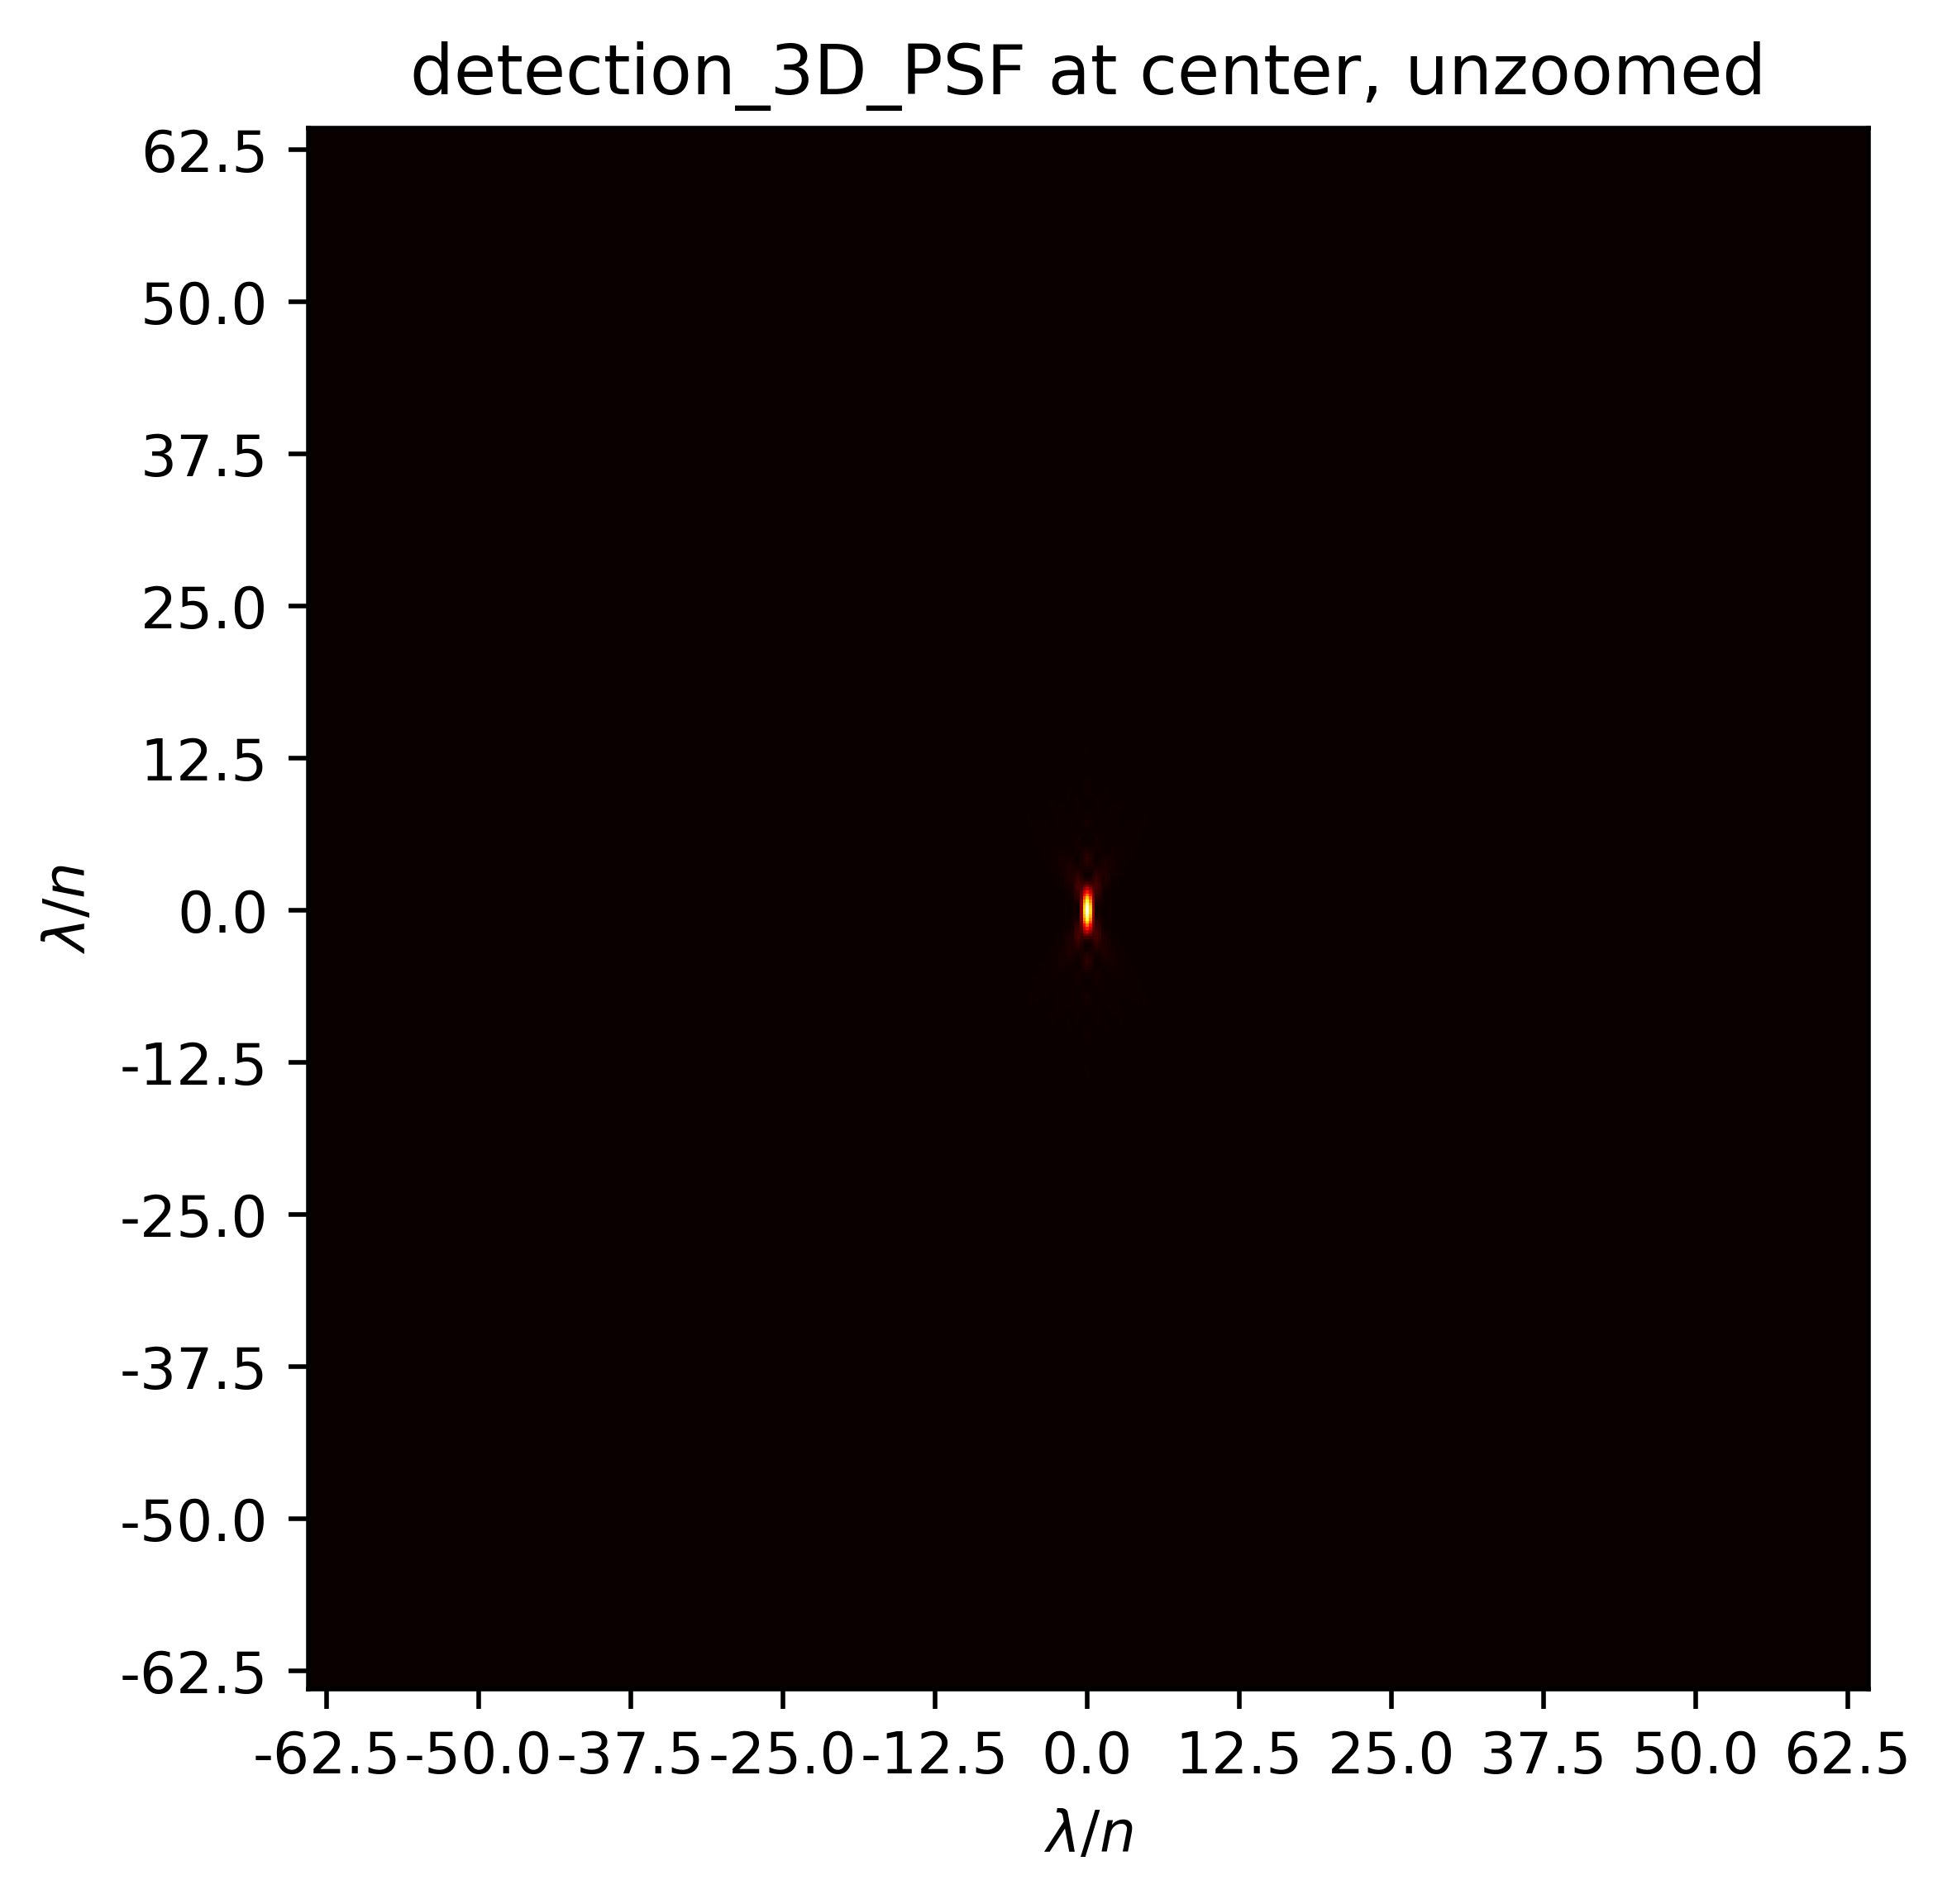

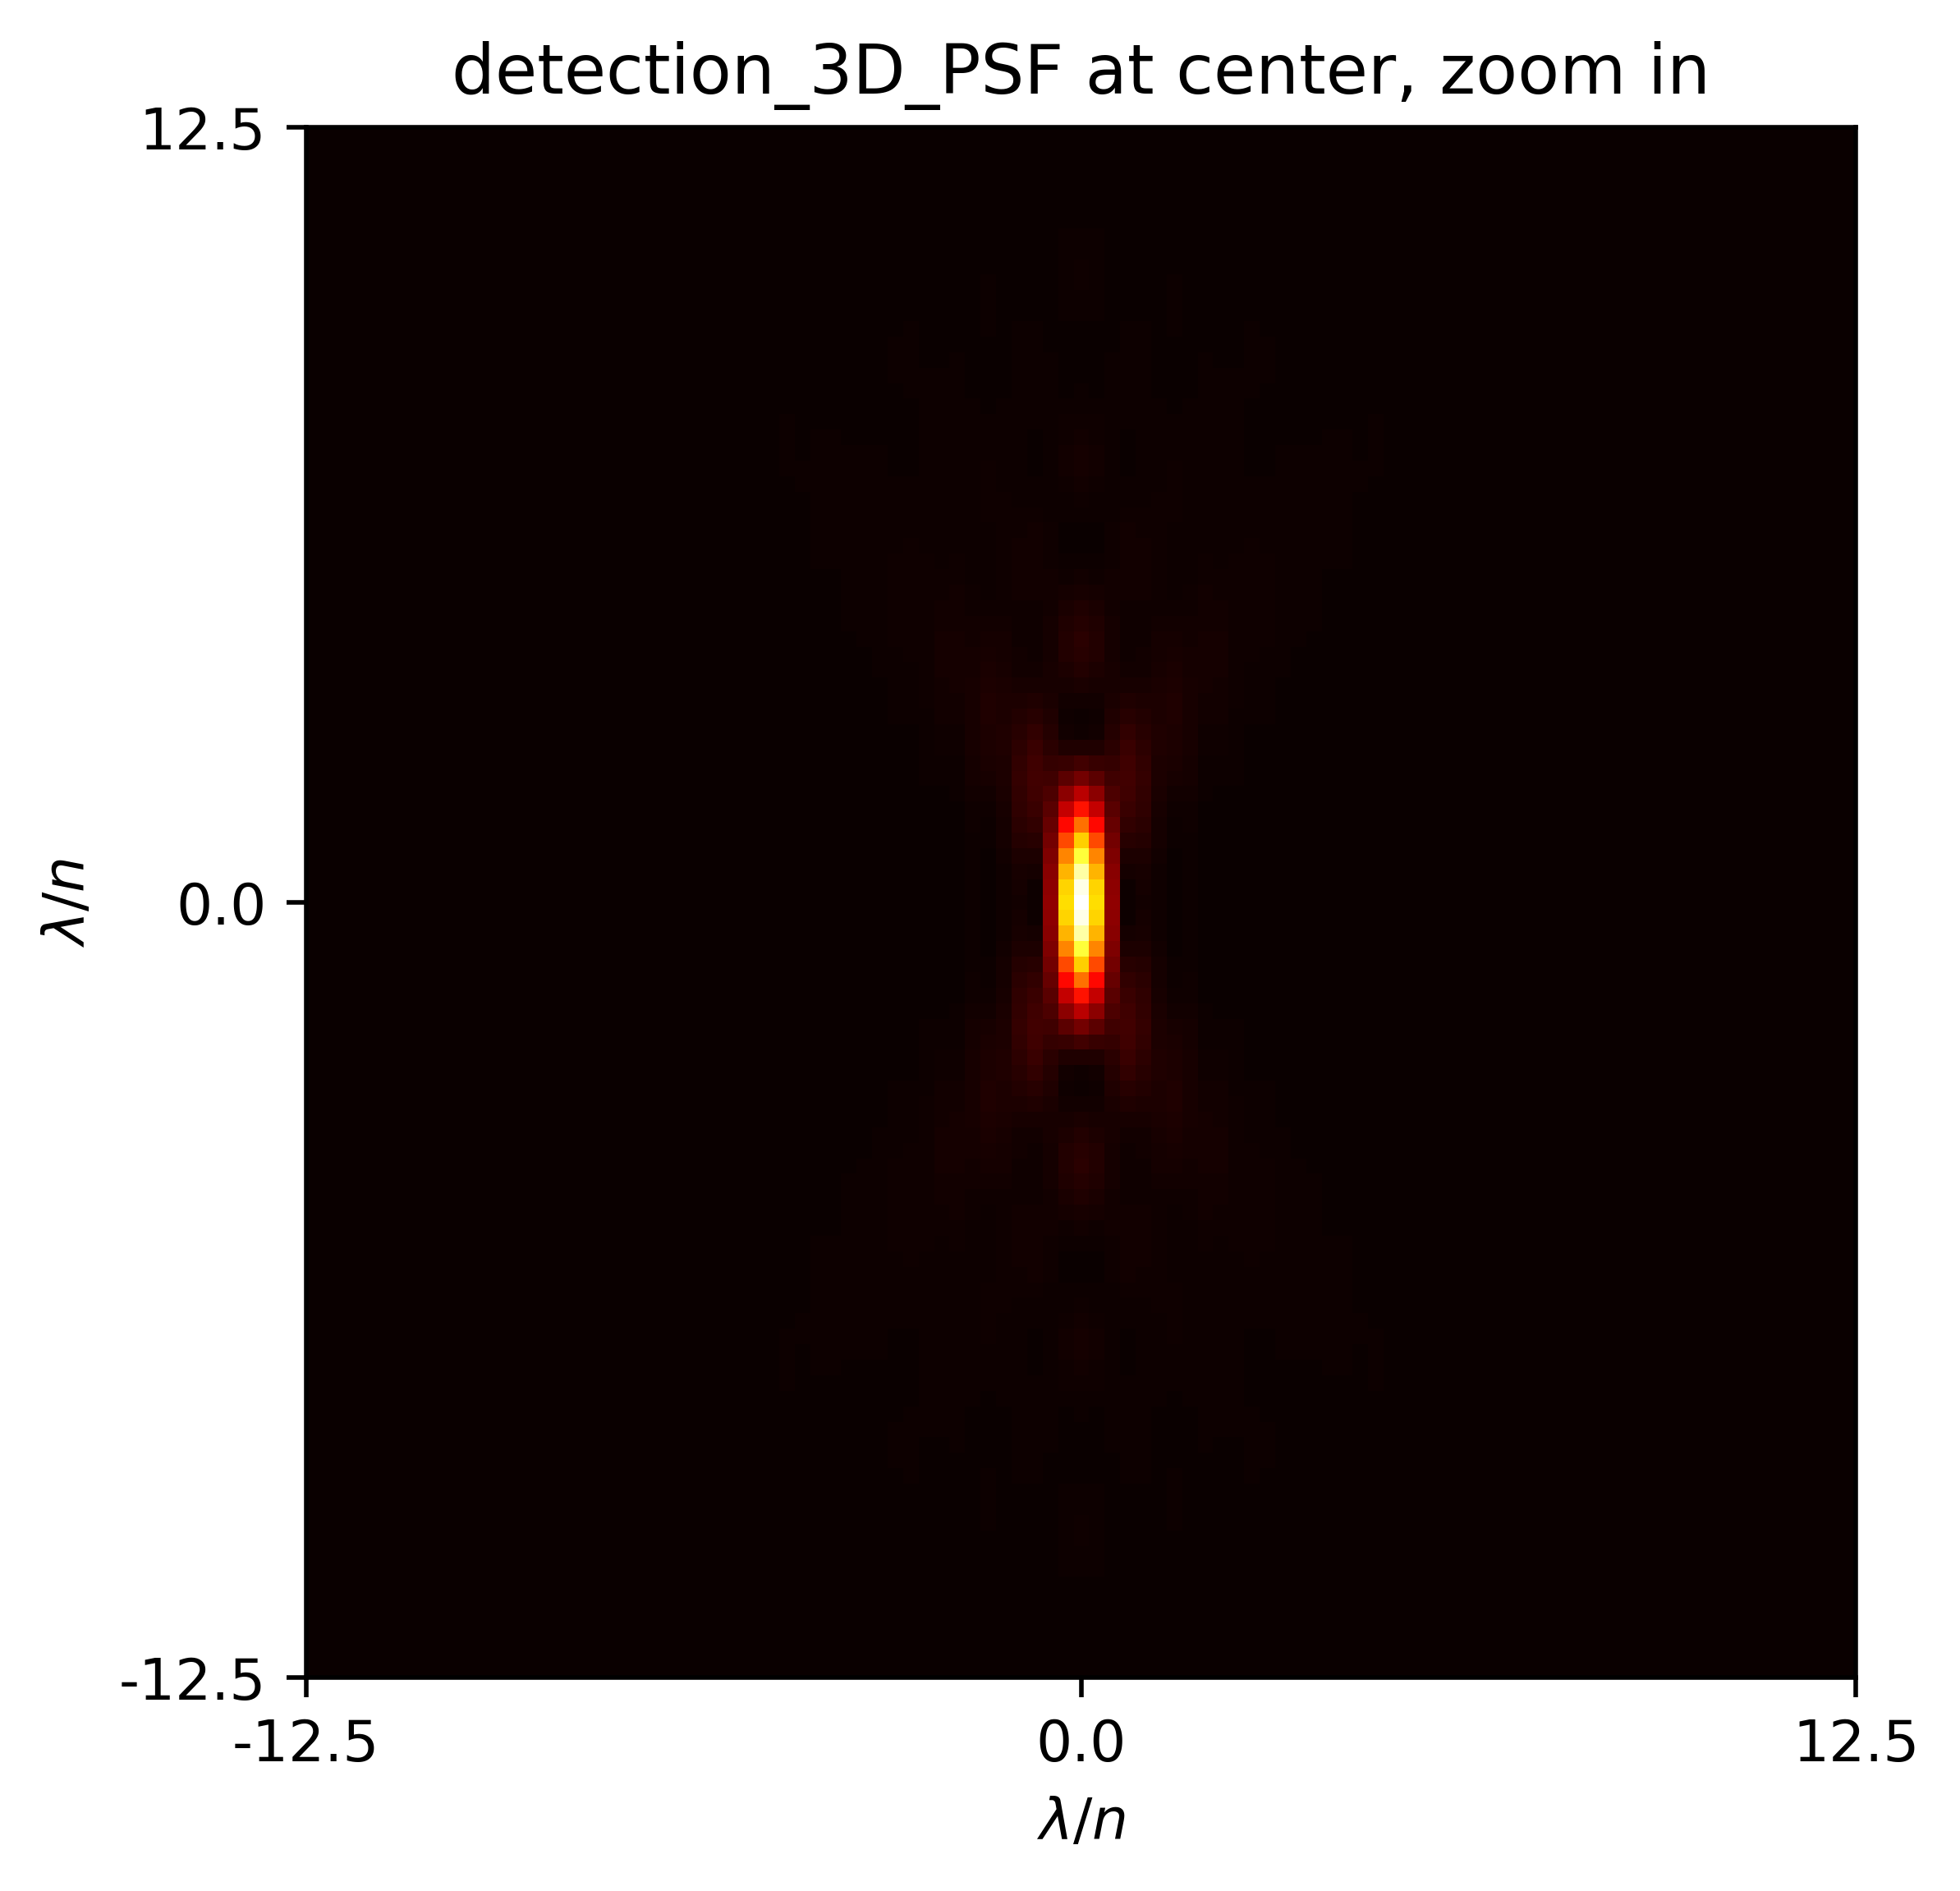

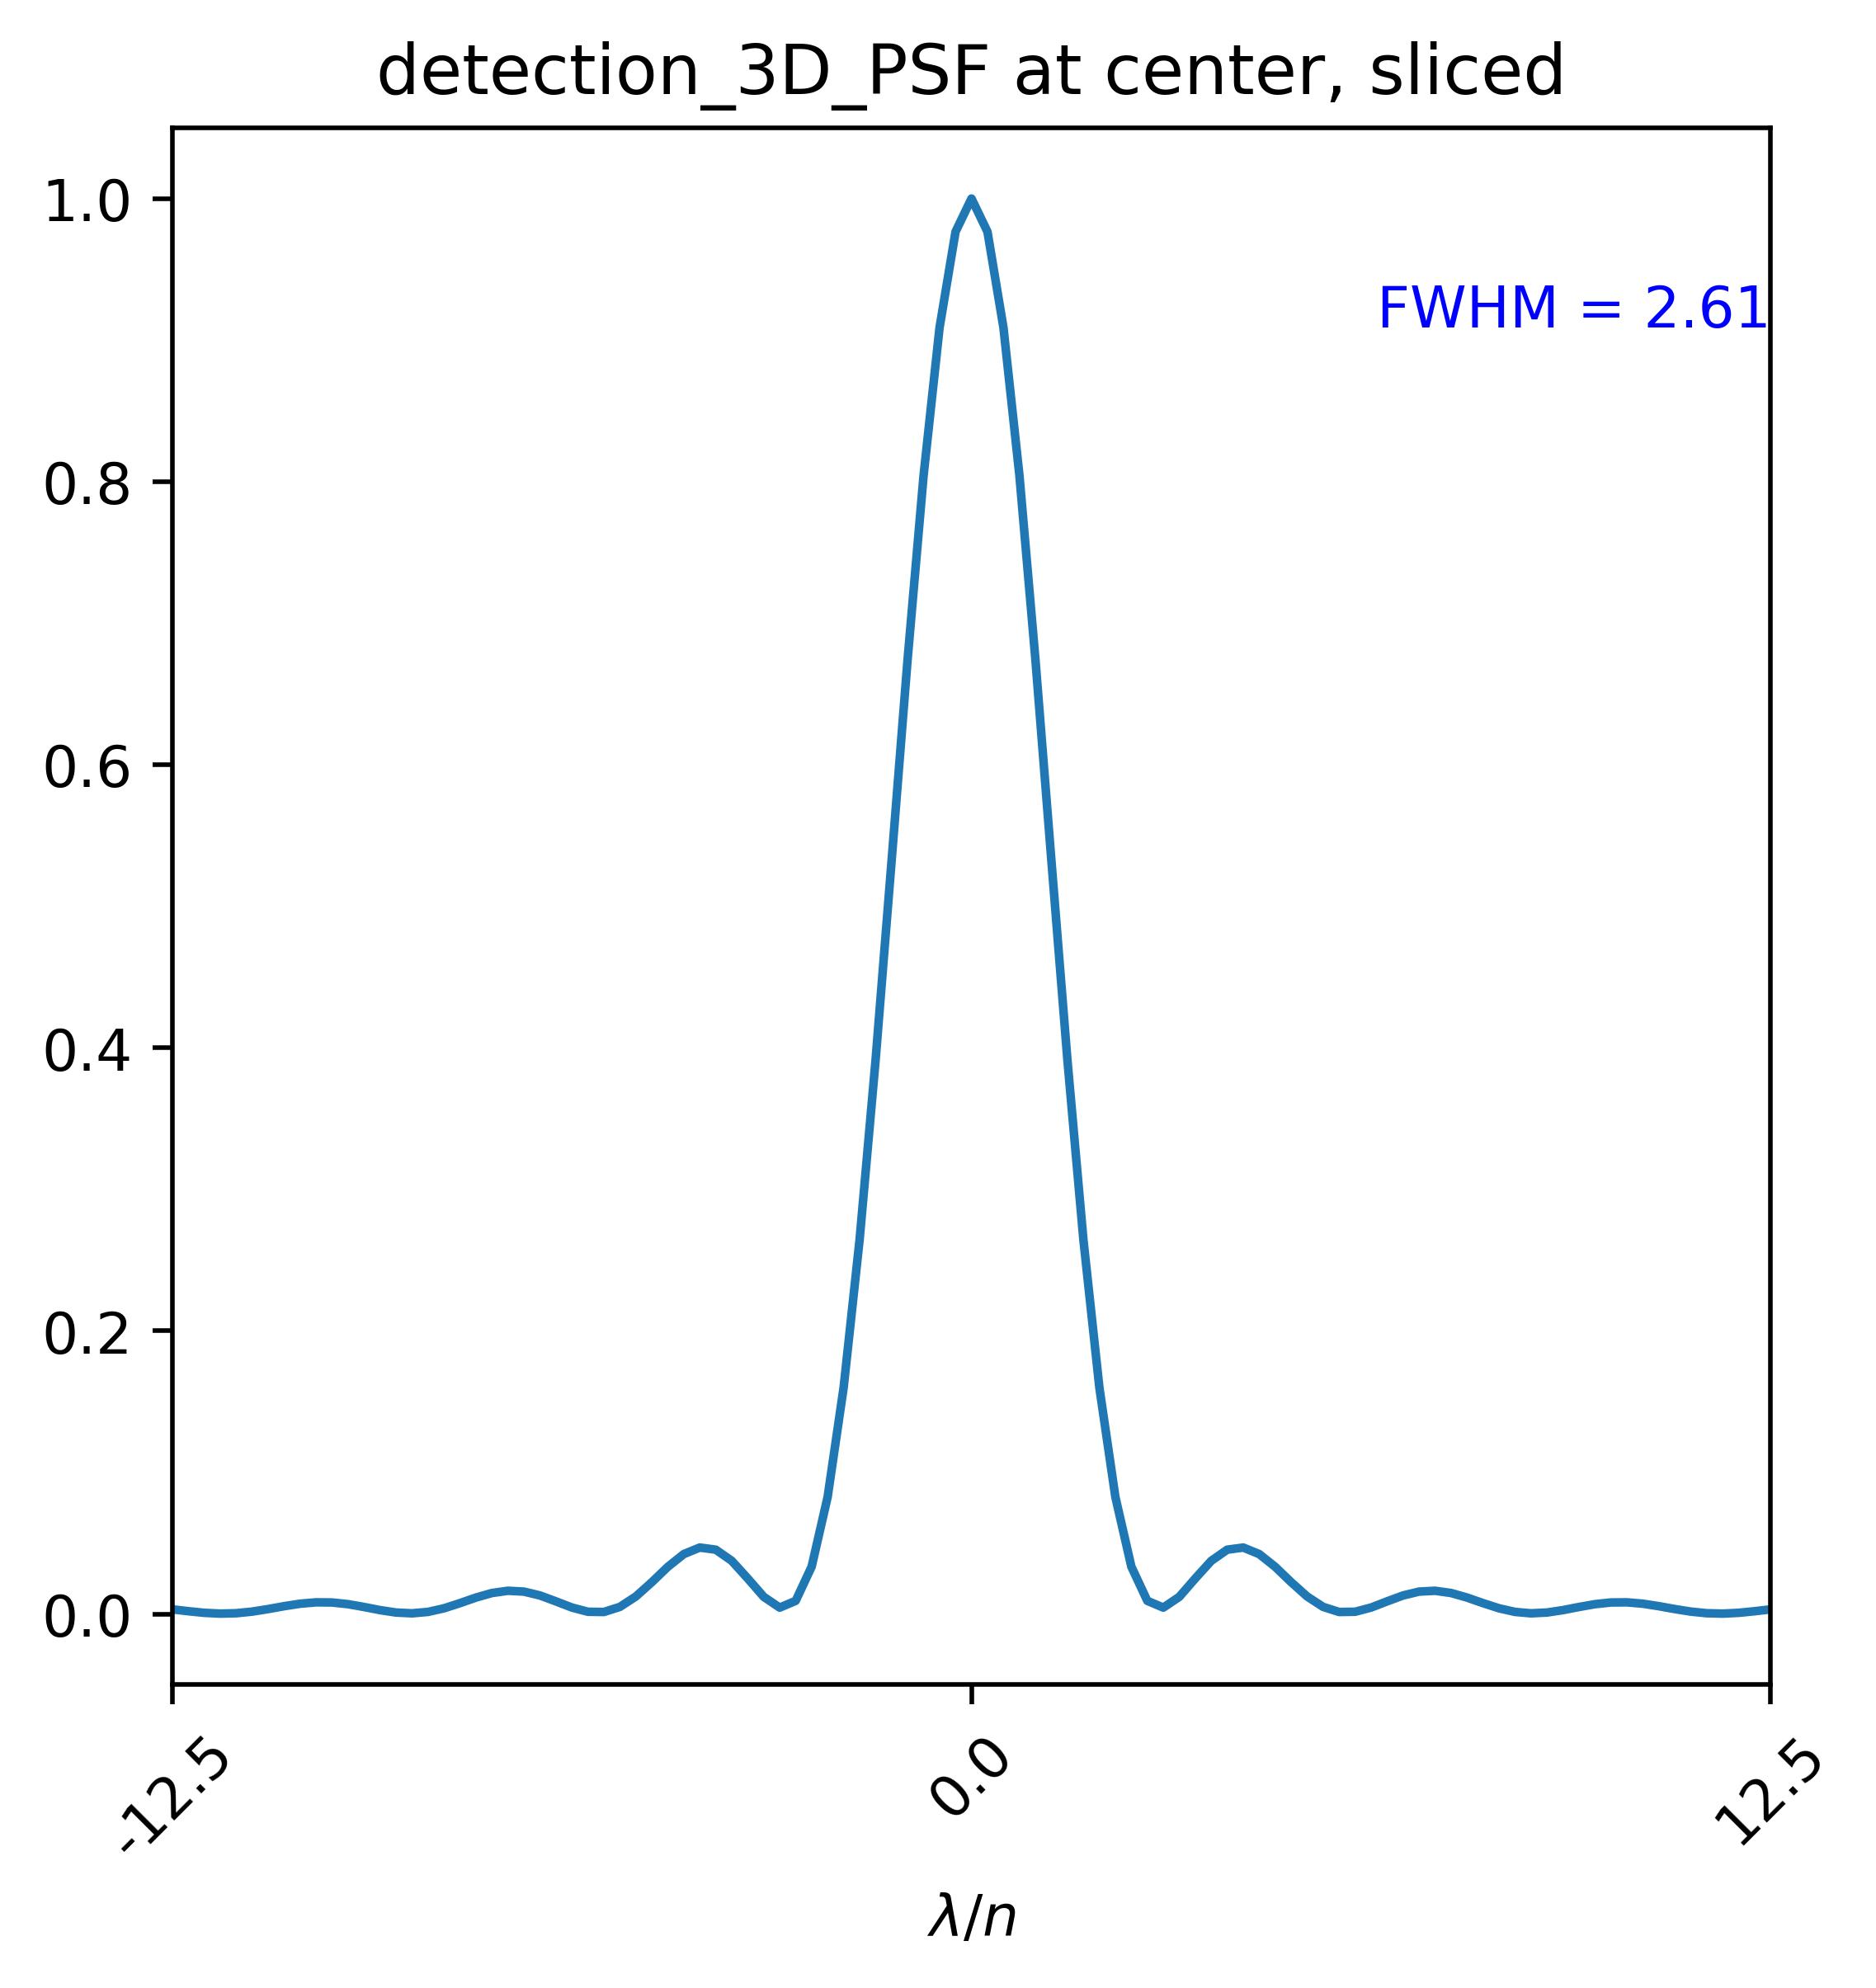

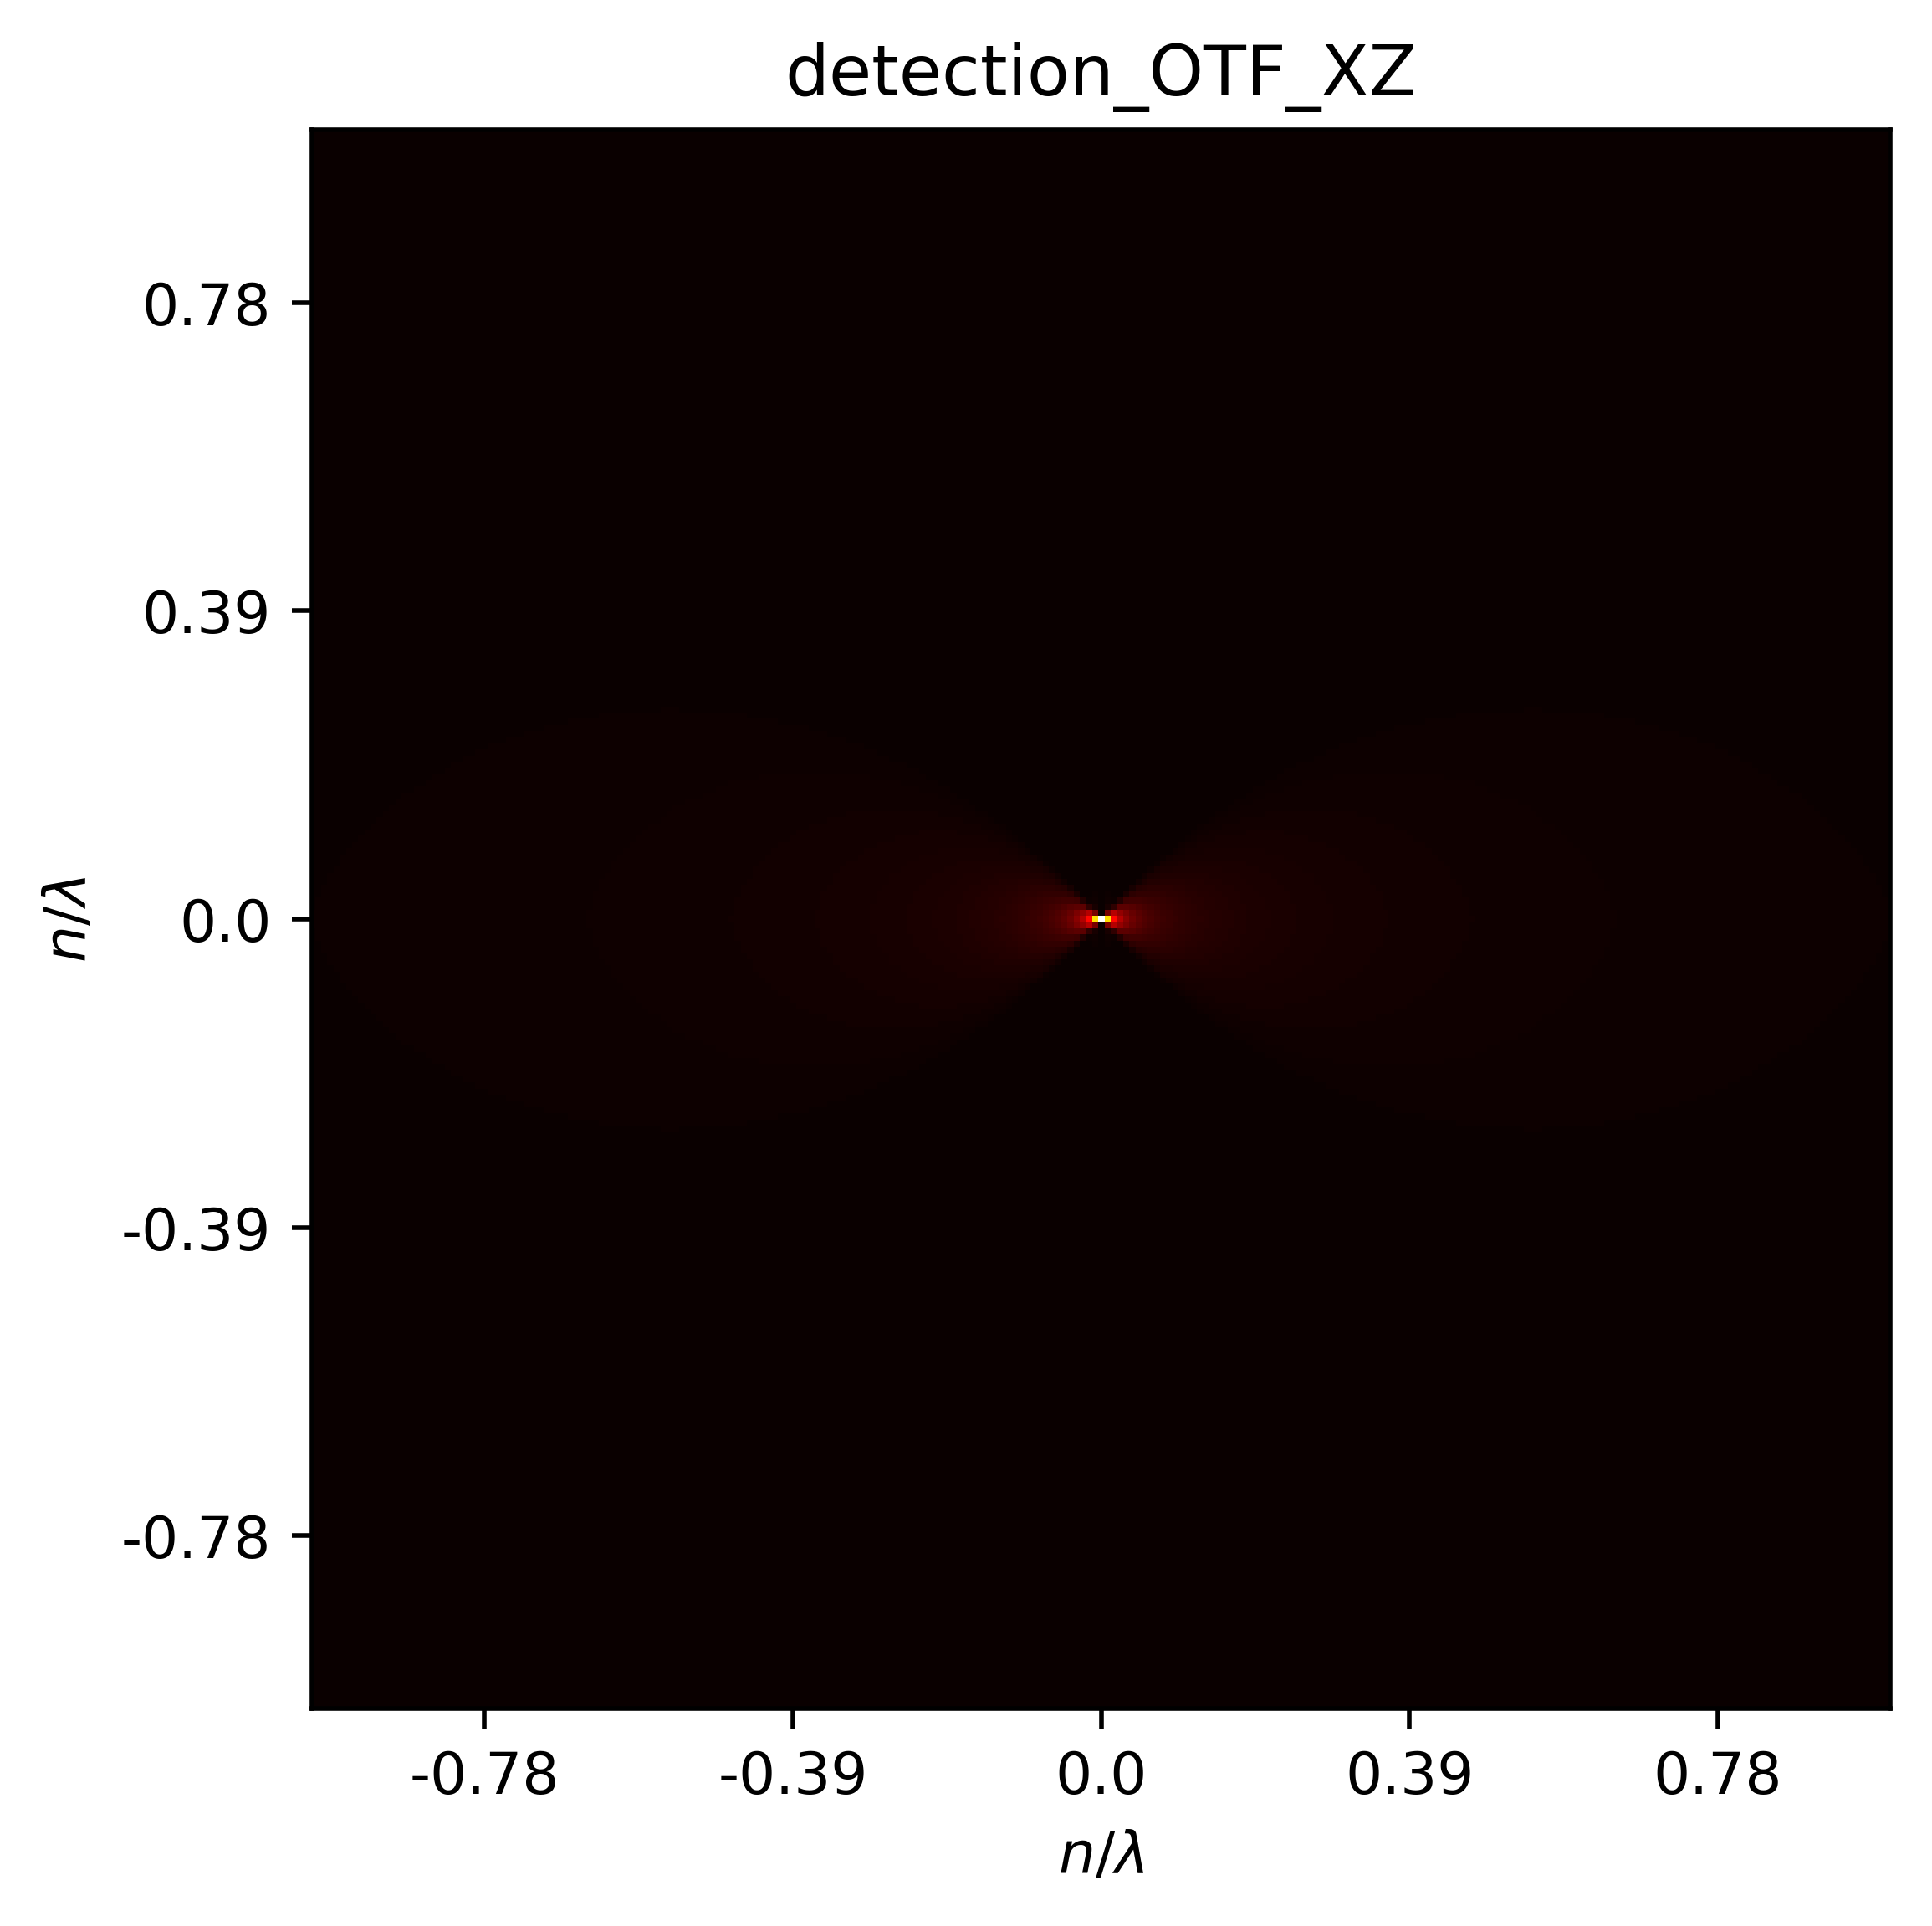

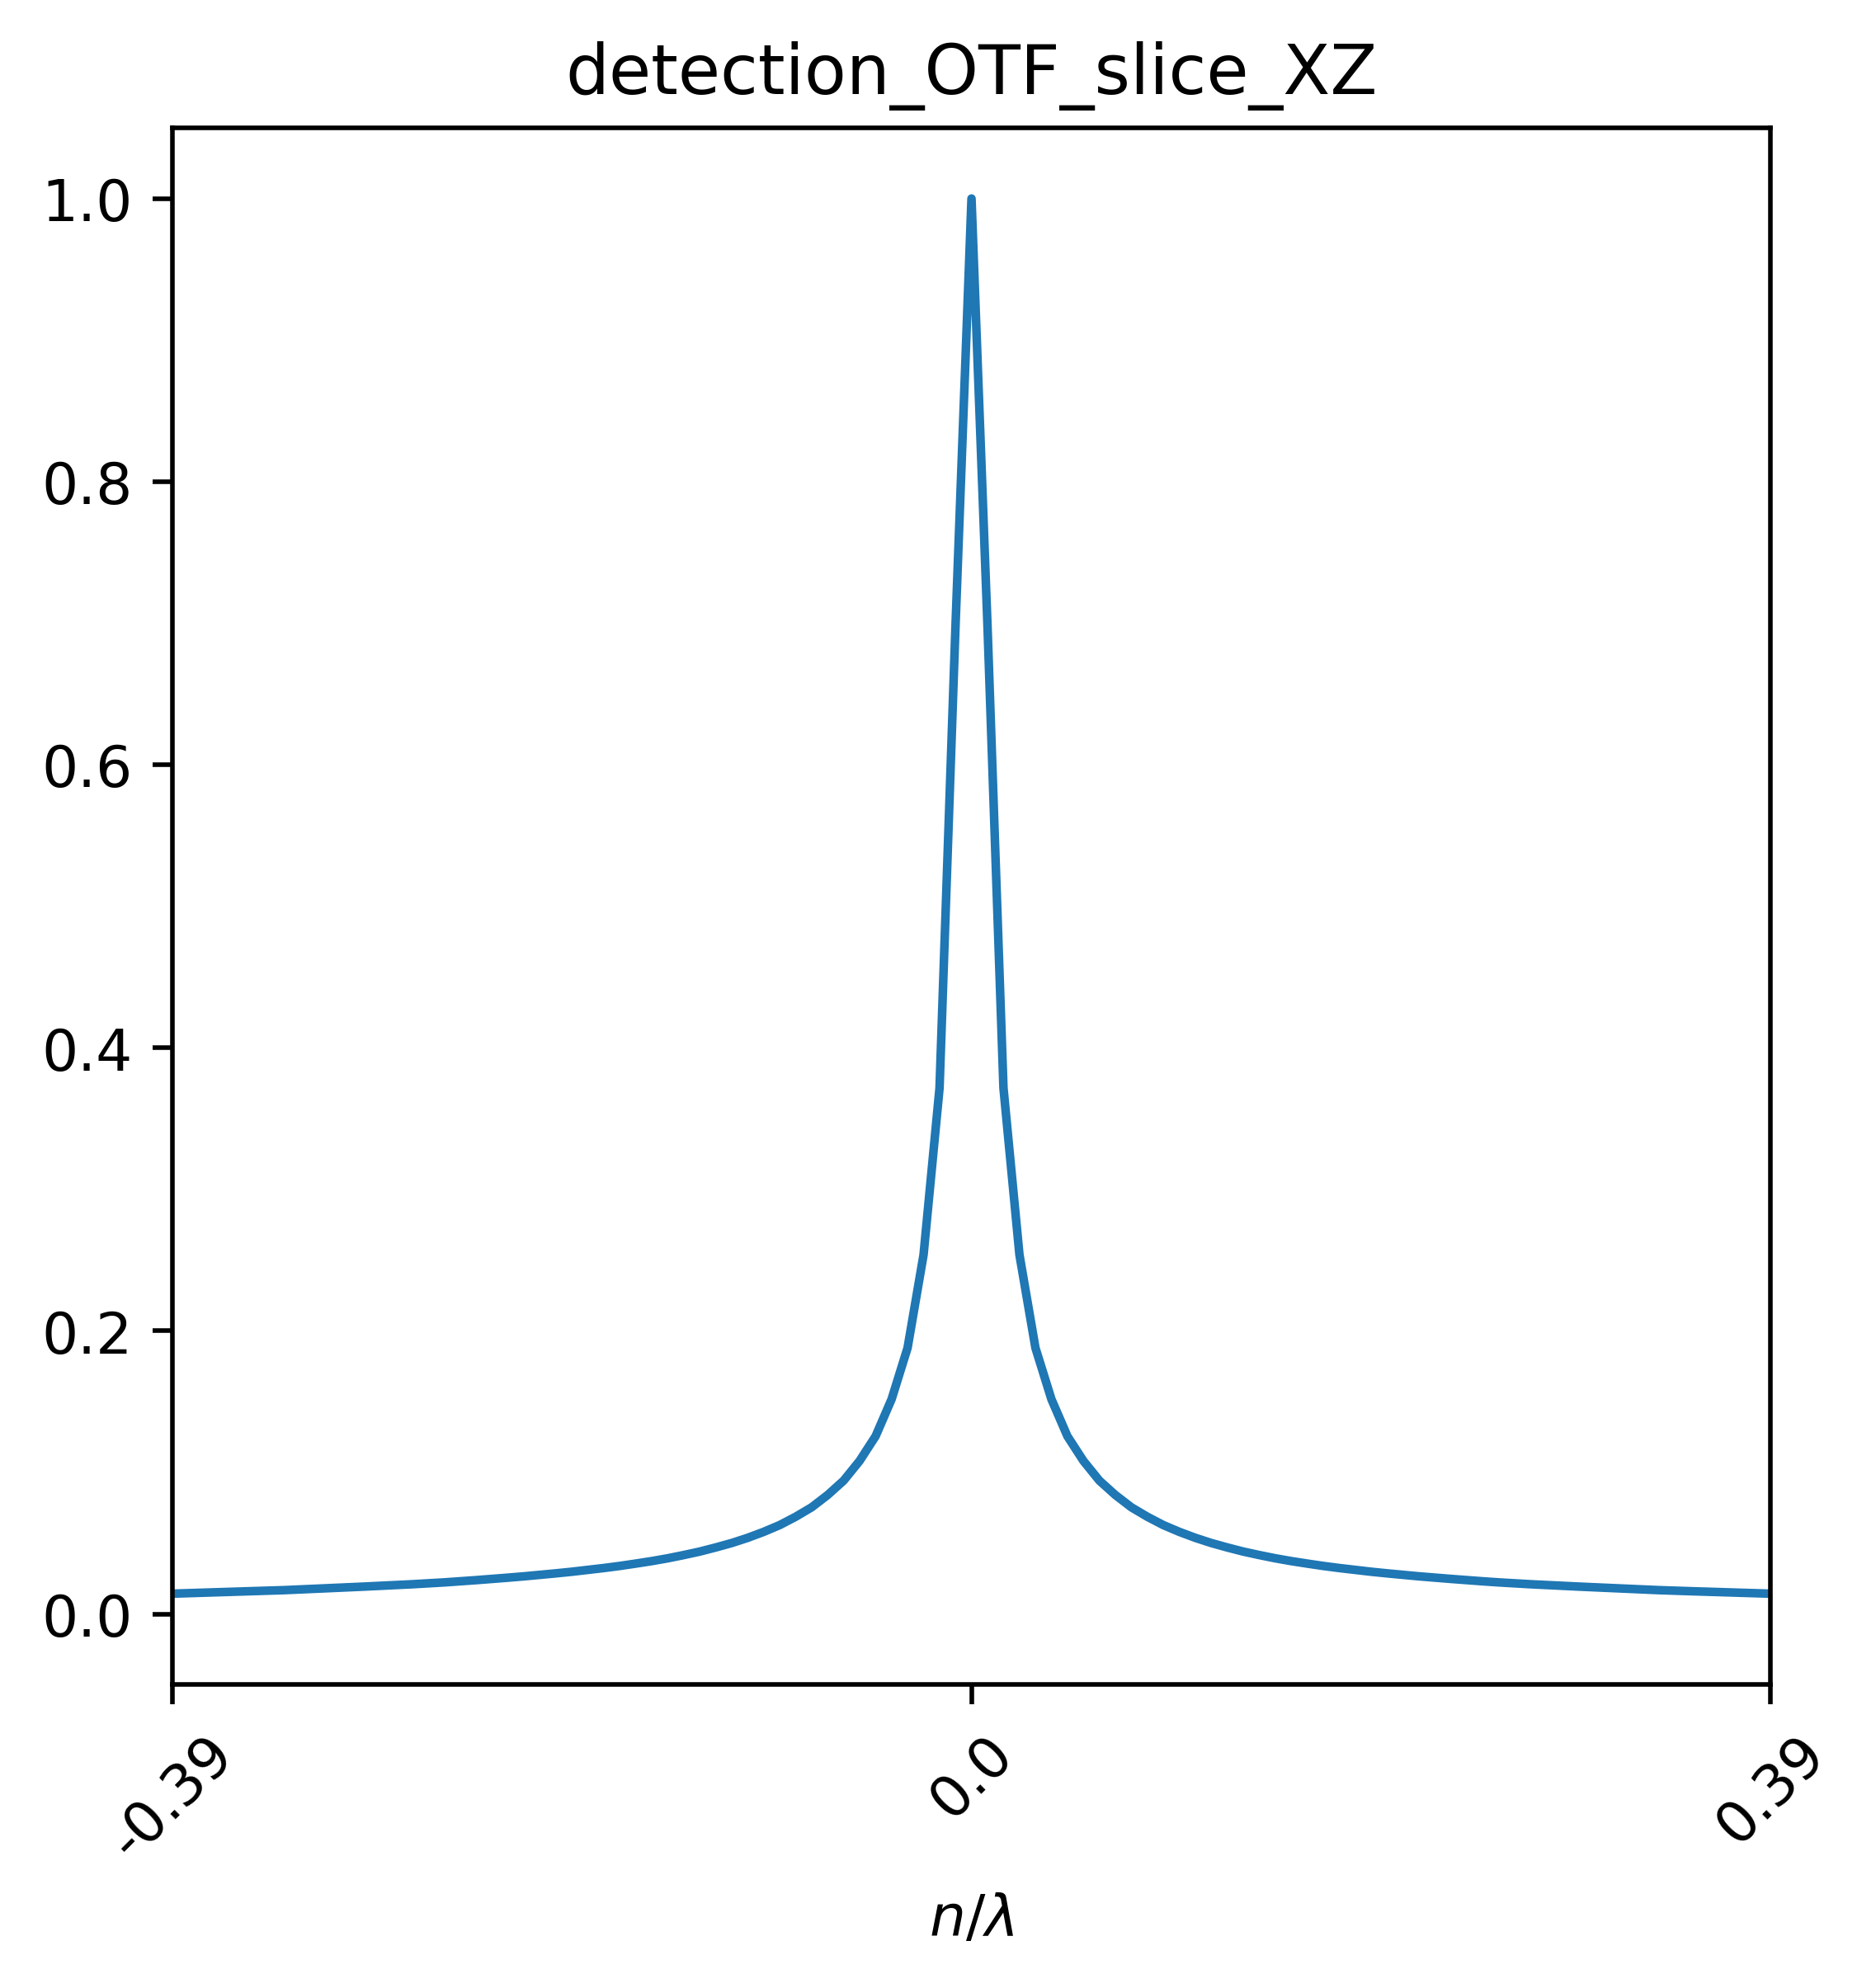

In [62]:
plot_xspace_setting(detection_3D[center], "detection_3D_PSF at center, unzoomed")
plot_xspace_setting(detection_3D[center], "detection_3D_PSF at center, zoom in", set_range=((center-50, center+50),(center-50,center+50)))
data = slice_graph(detection_3D[center], center, "xspace", "detection_3D_PSF at center, sliced", 'on', (center-50, center+50), hmfw = 'on' )


plot_kspace_setting(np.transpose(dct_OTF, (1,0,2))[center], "detection_OTF_XZ")
slice_graph(np.transpose(dct_OTF, (0,1,2))[center],center,'kspace','detection_OTF_slice_XZ',"off", (center - 50, center + 50));

In [52]:
%%time
## This section try to deal with Propagation

E_ideal = create_E_ideal_ini(SQR_points, 40)
pupil_E_bound = apply_NA_mask_pupil(E_ideal)
#pupil_E_bound = E_1

propagation_3D = propagation(pupil_E_bound, center+1)

propagation_OTF = np.fft.ifftshift(propagation_3D)
propagation_OTF = np.fft.fftn(propagation_OTF)
propagation_OTF = np.fft.fftshift(propagation_OTF)
propagation_OTF /= propagation_OTF[center][center][center] # normalize


progress : 0
progress : 100
progress : 200
CPU times: user 10.9 s, sys: 1.79 s, total: 12.7 s
Wall time: 12.7 s


In [1]:
plot_xspace_setting(np.transpose(propagation_3D, (2,1,0))[center], "propagation_3D_PSF at center, unzoomed")
data = slice_graph(np.transpose(propagation_3D, (2,0,1))[center], center, "xspace", "propagation_3D_PSF at center, sliced", 'on', hmfw = 'on' )

plot_kspace_setting(np.transpose(propagation_OTF, (0,1,2))[center], "propagation_OTF_XZ")
slice_graph(np.transpose(propagation_OTF, (0,1,2))[center],center,'kspace','propagation_OTF_slice_XZ',"on", (center - 50, center + 50));

NameError: name 'plot_xspace_setting' is not defined

In [ ]:
E1_propagation = np.copy(propagation_3D)

In [ ]:
E2_propagation = np.copy(propagation_3D)

In [ ]:
total_pro = E1_propagation + E2_propagation

In [ ]:
overall_PSF = detection_3D * total_pro

plot_xspace_setting(detection_3D[center], "detect", ((center-40, center+40),(center-40, center+40)))
plot_xspace_setting(total_pro[center], "excitation")
# plot_xspace_setting(propagation_3D[center], "excitation", ((center-40, center+40),(center-40, center+40)))
plot_xspace_setting(np.transpose(overall_PSF, (0,1,2))[center], "overall_PSF", ((center-40, center+40),(center-40, center+40)))
slice_graph(np.transpose(detection_3D, (0,1,2))[center],center,'xspace','dec',"on",  (center - 50, center+50))

slice_graph(np.transpose(total_pro, (0,1,2))[center],center,'xspace','exc',"on",  (center - 50, center+50))

slice_graph(np.transpose(overall_PSF, (0,1,2))[center],center,'xspace','overall',"on",  (center - 50, center+50))

In [ ]:
print("detect:", detection_3D.shape)
print("excitation:", propagation_3D.shape)
#plot_xspace_setting(propagation_3D[center], "test")

overall_PSF = detection_3D * propagation_3D
print("overall:", overall_PSF.shape)

plot_xspace_setting(detection_3D[center], "detect", ((center-40, center+40),(center-40, center+40)))
plot_xspace_setting(propagation_3D[center], "excitation")
# plot_xspace_setting(propagation_3D[center], "excitation", ((center-40, center+40),(center-40, center+40)))
plot_xspace_setting(np.transpose(overall_PSF, (0,1,2))[center], "overall_PSF", ((center-40, center+40),(center-40, center+40)))
slice_graph(np.transpose(detection_3D, (0,1,2))[center],center,'xspace','dec',"on",  (center - 50, center+50))

slice_graph(np.transpose(propagation_3D, (0,1,2))[center],center,'xspace','exc',"on",  (center - 50, center+50))

slice_graph(np.transpose(overall_PSF, (0,1,2))[center],center,'xspace','overall',"on",  (center - 50, center+50))

In [ ]:
overall_OTF = np.fft.ifftshift(overall_PSF)
overall_OTF = np.fft.fftn(overall_OTF)
overall_OTF = np.fft.fftshift(overall_OTF)

plot_kspace_setting(np.transpose(overall_OTF, (0,1,2))[center], "overall_OTF")
slice_graph(np.transpose(overall_OTF, (0,1,2))[center],center,'kspace','overall',"on")


In [ ]:
#image_file = ".png"
#image = plt.imread(image_filename)
#image = image[:, :, :3].mean(axis=2) # convert to grayscale

#array_size = len(image)
#center = int((array_size-1)/2)

amp = 1, 1, 1, 0
wavelength = 200, 200, 200, 200
degree = 30, 90, 150, 0

#for x in range(3):
#    amp += tuple([1])
#    wavelength += tuple([200])
#    degree += tuple([30*x])

sample_ini = np.zeros(X.shape)

for a,w,d in zip(amp, wavelength, degree):
    sample_ini += a * np.sin(2*np.pi* rotation_X(angle(d)) / w)

plt.set_cmap("gray")
plt.figure(figsize=(20,12))

plt.subplot(121)
plt.imshow(sample_ini)

plt.xlim(0, tot_range)
plt.ylim(0, tot_range)

pupil_from_sample = calculate_2dfft(sample_ini)

plt.subplot(122)

plt.imshow(pupil_from_sample)
plt.xlim(center-20, center+20)
plt.ylim(center-20, center+20) 

plt.show()